## Neural networks for segmentation

In [1]:
%env CUDA_VISIBLE_DEVICES=0,2,3
%env LIBRARY_PATH=/usr/local/cuda/lib64
import sys
sys.path.append("/home/shirobokov/.local/lib/python3.6/site-packages/")
DATA_PATH = "/home/shirobokov/data/DL_data"
import os

env: CUDA_VISIBLE_DEVICES=0,2,3
env: LIBRARY_PATH=/usr/local/cuda/lib64


Your next task is to train neural network to segment cells edges.

Here is an example of input data with corresponding ground truth:

In [2]:
import scipy as sp
import scipy.misc
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

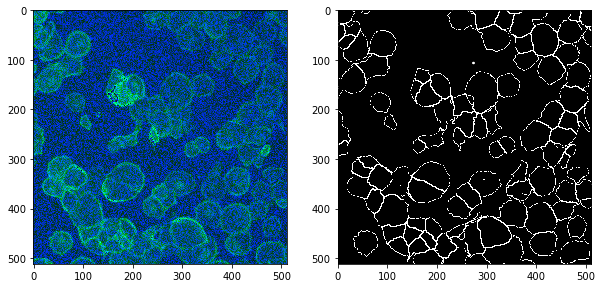

In [3]:
# Human HT29 colon-cancer cells
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
im = sp.misc.imread(os.path.join(DATA_PATH, 'BBBC018_v1_images-fixed/train/00735-actin.DIB.bmp'))
plt.imshow(im)
plt.subplot(1,2,2)
mask = sp.misc.imread(os.path.join(DATA_PATH, 'BBBC018_v1_outlines/train/00735-cells.png'))
plt.imshow(mask, 'gray')

This time you aren't provided with any code snippets, just input data and target metric - intersection-over-union (IoU) (see implementation below).

You should train neural network to predict mask of edge pixels (pixels in gt images with value greater than 0).

Use everything you've learnt by now: 
* any architectures for semantic segmentation (encoder-decoder like or based on dilated convolutions)
* data augmentation (you will need that since train set consists of just 41 images)
* fine-tuning

You're not allowed to do only one thing: to train you network on test set.

Your final solution will consist of an ipython notebook with code (for final network training + any experiments with data) and an archive with png images with network predictions for test images (one-channel images, 0 - for non-edge pixels, any non-zero value for edge pixels).

Forestalling questions about baseline... well, let's say that a good network should be able to segment images with iou >= 0.29. This is not a strict criterion of full points solution, but try to obtain better numbers.

Practical notes:
* There is a hard data class imbalance in dataset, so the network output will be biased toward "zero" class. You can either tune the minimal probability threshold for "edge" class, or add class weights to increase the cost of edge pixels in optimized loss.
* Dataset is small so actively use data augmentation: rotations, flip, random contrast and brightness
* Better spend time on experiments with neural network than on postprocessing tricks (i.e test set augmentation).
* Keep in mind that network architecture defines receptive field of pixel. If the size of network input is smaller than receptive field of output pixel, than probably you can throw some layers without loss of quality. It is ok to modify "of-the-shelf" architectures. 

Good luck!

In [4]:
def calc_iou(prediction, ground_truth):
    n_images = len(prediction)
    intersection, union = 0, 0
    for i in range(n_images):
        intersection += np.logical_and(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum() 
        union += np.logical_or(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum()
    return float(intersection) / union

# -------------

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class double_conv(nn.Module):
    '''(conv => BN => ReLU) * 2'''
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class inconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x


class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool2d(2),
            double_conv(in_ch, out_ch)
        )

    def forward(self, x):
        x = self.mpconv(x)
        return x


class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(up, self).__init__()

        #  would be a nice idea if the upsampling could be learned too,
        #  but my machine do not have enough memory to handle all those weights
        if bilinear:
            self.up = nn.Upsample(scale_factor=2)
        else:
            self.up = nn.ConvTranspose2d(in_ch, out_ch, 2, stride=2)

        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffX = x1.size()[2] - x2.size()[2]
        diffY = x1.size()[3] - x2.size()[3]
        x2 = F.pad(x2, (diffX // 2, int(diffX / 2),
                        diffY // 2, int(diffY / 2)))
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x


class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.conv(x)
        return x

In [6]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.inc = inconv(n_channels, 64)
        self.down1 = down(64, 128)
        self.down2 = down(128, 256)
        self.down3 = down(256, 512)
        self.down4 = down(512, 512)
        self.up1 = up(1024, 256)
        self.up2 = up(512, 128)
        self.up3 = up(256, 64)
        self.up4 = up(128, 64)
        self.outc = outconv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        return x

In [7]:
net = UNet(n_channels=3, n_classes=1).cuda()
#net = create_fully_conv_network()

In [8]:
##Parallel mode
net = nn.DataParallel(net)

In [9]:
def get_paths(mode='train'):
    val_images_dir = os.listdir(os.path.join(DATA_PATH, 'BBBC018_v1_images-fixed', mode))
    target_paths = []
    data_paths = []
    for index in range(len(val_images_dir)):
        base_name = val_images_dir[index]
        data_paths.append(os.path.join(DATA_PATH, 'BBBC018_v1_images-fixed', mode,
                                                        base_name))
        target_paths.append(os.path.join(DATA_PATH, 'BBBC018_v1_outlines', mode,
                                                     base_name.split('-')[0] + "-cells.png"))
    return data_paths, target_paths

In [10]:
train_paths, train_target_paths = get_paths()
val_paths, val_target_paths = get_paths('val')

In [11]:
from torch.utils.data import Dataset 
from PIL import Image
import random
from torchvision import transforms

In [12]:
class MyDataset(Dataset):
    def __init__(self, data_paths, target_paths, transform_X=None, transform_Y=None):
        self.data_paths = data_paths
        self.target_paths = target_paths
        self.transform_X = transform_X
        self.transform_Y = transform_Y
    
    def __getitem__(self, index):
        x = Image.open(self.data_paths[index])
        if self.transform_X:
            seed = np.random.randint(2147483647) # make a seed with numpy generator 
            random.seed(seed) # apply this seed to img tranfsorms
            x = self.transform_X(x)        
        if not self.target_paths:
            return x
        y = Image.open(self.target_paths[index])
        if self.transform_Y:
            random.seed(seed)
            y = self.transform_Y(y)
        y = (np.array(y, dtype=np.float32)[None, :, :] > 0).astype(np.float32)
        return x, y 

    def __len__(self):
        return len(self.data_paths)

In [13]:
means = np.array((0.4914, 0.4822, 0.4465))
stds = np.array((0.2023, 0.1994, 0.2010))

transform_X = transforms.Compose([
    transforms.RandomCrop(256, padding=0),
    #transforms.RandomRotation([-60, 60]),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(means, stds),
])

transform_Y = transforms.Compose([
    transforms.RandomCrop(256, padding=0),
    #transforms.RandomRotation([-60, 60]),
    transforms.RandomHorizontalFlip(),
])

train_dataset = MyDataset(train_paths, train_target_paths, transform_X=transform_X, transform_Y=transform_Y)

train_batch_gen = torch.utils.data.DataLoader(train_dataset, 
                                              batch_size=10,
                                              shuffle=True,
                                              num_workers=3)

transform_test = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize(means, stds),
])

val_dataset = MyDataset(val_paths, val_target_paths, transform_X=transform_test, transform_Y=None)

val_batch_gen = torch.utils.data.DataLoader(val_dataset, 
                                            batch_size=3,
                                            shuffle=False,
                                            num_workers=3)




for (x_batch, y_batch) in train_batch_gen:

    print('X:', type(x_batch), x_batch.shape)
    print('y:', type(y_batch), y_batch.shape)
    
#     plt.figure(figsize=(20,7))
#     for i, img, gt in zip(range(x_batch.shape[0]), x_batch, y_batch):
#         plt.subplot(2, len(y_batch), i+1)
#         plt.imshow((np.array(img) * stds[:, None,None] + means[:, None, None]).transpose([1,2,0]))
#         plt.subplot(2, len(y_batch), i+1 + x_batch.shape[0])
#         plt.imshow(gt[0, :, :], 'gray')
        
    
#     raise NotImplementedError("Plese use this code in your training loop")
#     # TODO use this in your training loop

X: <class 'torch.FloatTensor'> torch.Size([10, 3, 256, 256])
y: <class 'torch.FloatTensor'> torch.Size([10, 1, 256, 256])
X: <class 'torch.FloatTensor'> torch.Size([10, 3, 256, 256])
y: <class 'torch.FloatTensor'> torch.Size([10, 1, 256, 256])
X: <class 'torch.FloatTensor'> torch.Size([10, 3, 256, 256])
y: <class 'torch.FloatTensor'> torch.Size([10, 1, 256, 256])
X: <class 'torch.FloatTensor'> torch.Size([10, 3, 256, 256])
y: <class 'torch.FloatTensor'> torch.Size([10, 1, 256, 256])
X: <class 'torch.FloatTensor'> torch.Size([1, 3, 256, 256])
y: <class 'torch.FloatTensor'> torch.Size([1, 1, 256, 256])


In [14]:
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

from scipy.special import expit

In [15]:
def compute_loss(X_batch, y_batch):
    X_batch = Variable(X_batch).cuda()
    y_batch = Variable(y_batch).cuda()
    logits = net(X_batch)
    return F.binary_cross_entropy_with_logits(logits, y_batch)

In [16]:
import time
from pandas import ewma
from IPython import display        
        
#opt = torch.optim.SGD(net.parameters(), lr=1e-3)
opt = torch.optim.Adam(net.parameters(), lr=1e-3)

num_epochs = 100 # total amount of full passes over training data

train_loss = []
val_accuracy = []

In [32]:
opt = torch.optim.Adam(net.parameters(), lr=1e-3 / 2) 

In [33]:
num_epochs = 50

## 200 iter with lr=1e-3 + 50iter 1e-3/2

In [34]:
for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    start_time = time.time()
    net.train(True) # enable dropout / batch_norm training behavior
    loss_batch = []
    for (X_batch, y_batch) in train_batch_gen:
        # train on batch
        loss = compute_loss(X_batch, y_batch)
        loss.backward()
        opt.step()
        opt.zero_grad()
        loss_batch.append(loss.data.cpu().numpy()[0])
    train_loss.append(np.mean(loss_batch))
    # And a full pass over the validation data:
    net.train(False) # disable dropout / use averages for batch_norm

    val_iou = []
    for (X_batch, y_batch) in val_batch_gen:
        logits = net(Variable(X_batch, volatile=True).cuda())
        y_pred = logits.data.cpu().numpy()
        #val_accuracy.append(np.mean(y_batch == y_pred))
        val_iou.append(calc_iou(expit(y_pred) > 0.33, y_batch.numpy()))
        
    val_accuracy.append(np.mean(val_iou))
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(train_loss[-1]))
#     print("  validation accuracy: \t\t\t{:.2f} %".format(
#         np.mean(val_accuracy[-len(X_val) // batch_size :]) * 100))
    print("  validation iou:\t\t{:.2f} %".format(val_accuracy[-1] * 100))

Epoch 1 of 50 took 5.397s
  training loss (in-iteration): 	0.085102
  validation iou:		27.17 %
Epoch 2 of 50 took 5.179s
  training loss (in-iteration): 	0.097943
  validation iou:		27.86 %
Epoch 3 of 50 took 4.935s
  training loss (in-iteration): 	0.113961
  validation iou:		27.77 %
Epoch 4 of 50 took 5.004s
  training loss (in-iteration): 	0.092043
  validation iou:		29.18 %
Epoch 5 of 50 took 5.048s
  training loss (in-iteration): 	0.083857
  validation iou:		27.72 %
Epoch 6 of 50 took 4.913s
  training loss (in-iteration): 	0.070911
  validation iou:		27.48 %
Epoch 7 of 50 took 5.050s
  training loss (in-iteration): 	0.083706
  validation iou:		28.82 %
Epoch 8 of 50 took 5.159s
  training loss (in-iteration): 	0.078577
  validation iou:		27.90 %
Epoch 9 of 50 took 4.933s
  training loss (in-iteration): 	0.104678
  validation iou:		28.86 %
Epoch 10 of 50 took 5.199s
  training loss (in-iteration): 	0.113246
  validation iou:		28.01 %
Epoch 11 of 50 took 5.372s
  training loss (in-it

In [48]:
# with open("u_net_val_30.pt", 'wb') as f:
#     torch.save(net, f)

In [35]:
# import gc
# del net
# gc.collect()

In [36]:
net.train(False)
image, answer = next(iter(val_batch_gen))

In [37]:
np.unique(answer)

array([0., 1.], dtype=float32)

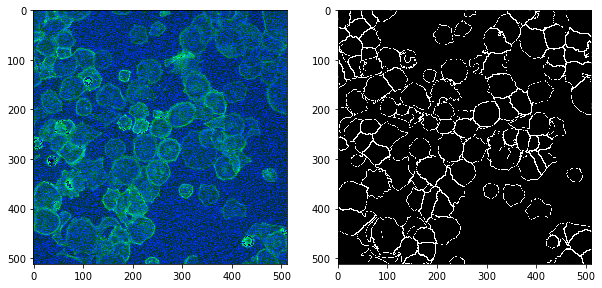

In [38]:
im = (np.array(image)[0] * stds[:, None,None] + means[:, None, None]).transpose([1,2,0])
mask = answer.numpy()[0][0]
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
plt.imshow(im)
plt.subplot(1,2,2)
plt.imshow(mask, 'gray')

In [39]:
res = net(Variable(image).cuda()).data.cpu().numpy()

In [40]:
print(expit(res[0][0]).min(), expit(res[0][0]).max())

2.9953415e-07 0.59341437


In [41]:
t_range = np.arange(0.05, 0.45, 0.01)
iou_values = [calc_iou(expit(res[0][0]) > tr, answer.numpy()[0][0]) for tr in t_range]
best_tr = np.argmax([calc_iou(expit(res[0][0]) > tr, answer.numpy()[0][0]) for tr in t_range])
print(np.arange(0.1, 0.38, 0.01)[best_tr], np.max(iou_values))

0.2599999999999999 0.3803689241955029


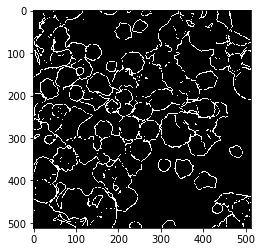

In [42]:
plt.imshow(expit(res[0][0]) > 0.26, 'gray')

# Validation score

In [46]:
res = []
ans = []
for image, answer in val_batch_gen:
    res.append(net(Variable(image).cuda()).data.cpu().numpy())
    ans.append(answer.numpy())
print(calc_iou(expit(np.concatenate(res)) > 0.26, np.concatenate(ans)))

0.3015567324666988
